## Импорт библиотек

In [1]:
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from read_db.CH import Getch
import pandas as pd

## Выгружаем данные из таблицы

In [2]:
query = """
select user_id
    , countIf(user_id, action = 'view') as views
    , countIf(user_id, action = 'like') as likes
    , likes/views as ctr
    , exp_group
    , xxHash64(user_id)%50 as bucket
from simulator_20220520.feed_actions
where toDate(time) between '2022-04-24' and '2022-04-30'
and exp_group in (1,2)
group by user_id, exp_group
"""

df = Getch(query).df

In [3]:
df.groupby('exp_group').count()

,user_id,views,likes,ctr
exp_group,,,,
1,10079,10079,10079,10079
2,9952,9952,9952,9952


Группы приблизительно равны. Посмотрим на распределение CTR по группам:

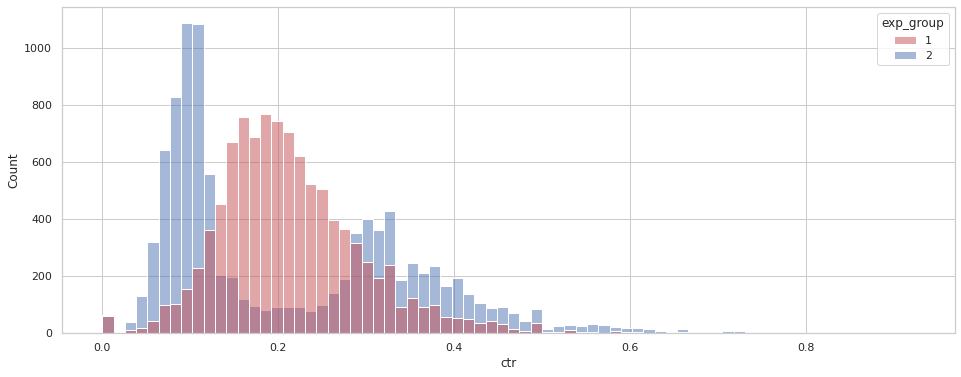

In [4]:
sns.set(rc={'figure.figsize': (16, 6)}, style="whitegrid")
sns.histplot(data=df,
              x='ctr',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
plt.show()

## t - тест

In [5]:
stats.ttest_ind(df[df['exp_group'] == 1]['ctr'],
          df[df['exp_group'] == 2]['ctr'],
          equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

Оба распределения скошены, а CTR группы 2 вообще не унимодально. Поэтому т-тест Стьюдента не показала статистически значимого отличия между группами.

## Манна-Уитни

In [6]:
stats.mannwhitneyu(df[df['exp_group'] == 1]['ctr'],
             df[df['exp_group'] == 2]['ctr'],
             alternative='two-sided')

MannwhitneyuResult(statistic=56601260.5, pvalue=6.0376484617779035e-56)

Данный тест является непраметрическим, поэтому подобные распределения для него не срашны. Соответственно мы получили статистически значимое отличие между группами.

## Сглаженный CTR

In [7]:
def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
    smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smothed_ctr

In [8]:
global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group = df.copy()

#задаем параметр сглаживания
alpha_smooth = 5

#рассчитаем CTR по каждой группе
group['group_ctr'] = group.groupby('exp_group')['likes'].transform(sum) / group.groupby('exp_group')['views'].transform(sum)

#считаем сглаженный ctr
group['smothed_ctr'] = (group['likes'] + alpha_smooth * group['group_ctr']) / (group['views'] + alpha_smooth)

In [9]:
group.head()

,user_id,views,likes,ctr,exp_group,group_ctr,smothed_ctr
0,109963,15,3,0.200000,1,0.208027,0.202007
1,26117,141,32,0.226950,1,0.208027,0.226302
2,138232,73,18,0.246575,1,0.208027,0.244104
3,26295,122,33,0.270492,1,0.208027,0.268033
4,18392,32,7,0.218750,1,0.208027,0.217301


<AxesSubplot:xlabel='smothed_ctr', ylabel='Count'>

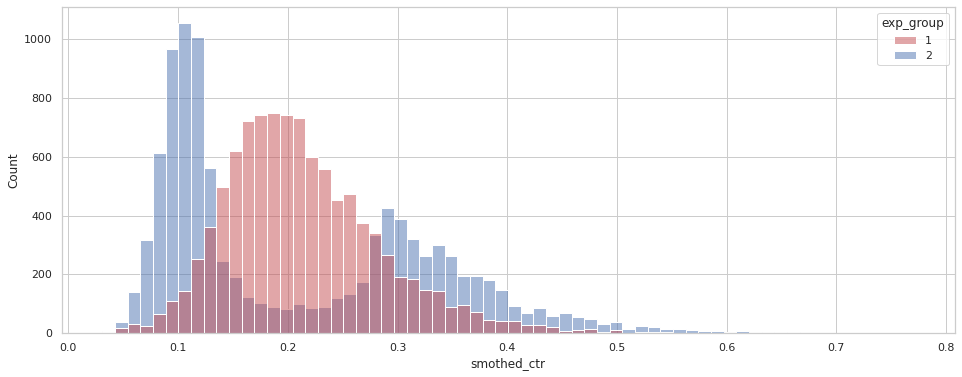

In [10]:
 sns.histplot(data=group,
              x='smothed_ctr',
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

In [11]:
stats.ttest_ind(group[group['exp_group'] == 1]['smothed_ctr'],
          group[group['exp_group'] == 2]['smothed_ctr'],
          equal_var=False)

Ttest_indResult(statistic=2.2841320431616983, pvalue=0.0223769815558559)

In [12]:
stats.mannwhitneyu(group[group['exp_group'] == 1]['smothed_ctr'],
             group[group['exp_group'] == 2]['smothed_ctr'],
             alternative='two-sided')

MannwhitneyuResult(statistic=56925125.0, pvalue=1.6163964114270227e-61)

Сглаживание позволило повысить чувствительность т-теста. В этот раз мы с его помощью смогли отловить стат значимую разницу.

## Пуасоновский бустреп

In [13]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = stats.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = stats.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [14]:
 #подготовим данные для расчета
likes1 = df[df['exp_group'] == 1]['likes'].to_numpy()
views1 = df[df['exp_group'] == 1]['views'].to_numpy()
likes2 = df[df['exp_group'] == 2]['likes'].to_numpy()
views2 = df[df['exp_group'] == 2]['views'].to_numpy()

In [15]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

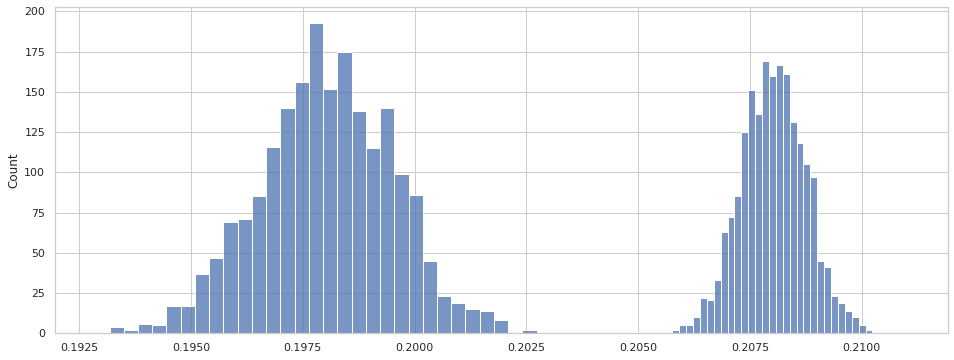

In [16]:
 #визуализируем результат
sns.histplot(ctr1)
sns.histplot(ctr2)
plt.show()

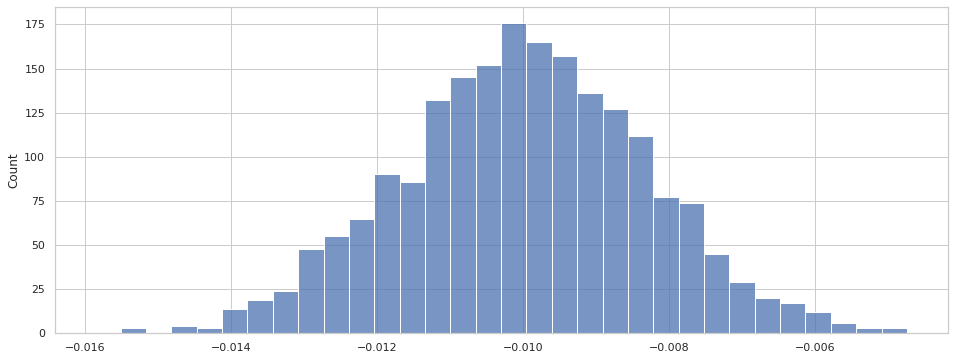

In [18]:
sns.histplot(ctr2 - ctr1)
plt.show()

С помощью этого метода мы смогли наглядно продемонстрировать различие значения CTR между группами.

## Бакетное преобразование

In [25]:
query = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM simulator_20220520.feed_actions 
    WHERE toDate(time) between '2022-04-24' and '2022-04-30'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

bucket_df = Getch(query).df

In [26]:
bucket_df

,exp_group,bucket,bucket_ctr
0,1,0,0.196481
1,2,0,0.194262
2,1,1,0.211887
3,2,1,0.215328
4,1,2,0.206271
...,...,...,...
95,2,47,0.195880
96,1,48,0.212787
97,2,48,0.194502
98,1,49,0.203169


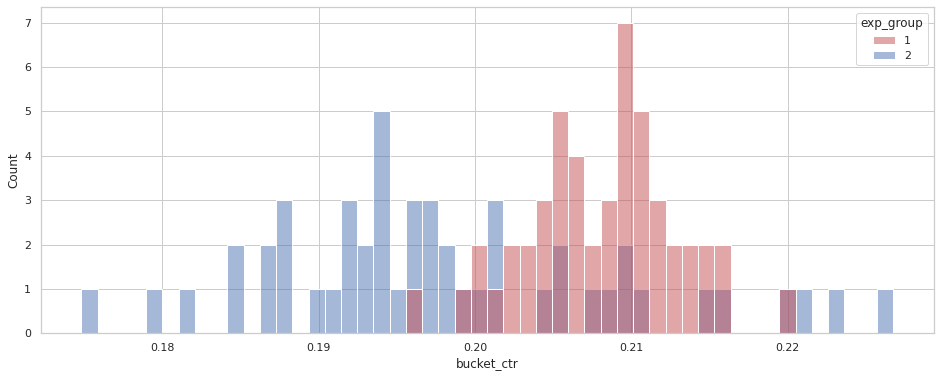

In [28]:
sns.histplot(data=bucket_df,
              x='bucket_ctr',
              hue='exp_group',
              palette = ['r', 'b'],
              bins=50,
              alpha=0.5,
              kde=False)
plt.show()

In [32]:
 stats.ttest_ind(bucket_df[bucket_df['exp_group'] == 1]['bucket_ctr'],
          bucket_df[bucket_df['exp_group'] == 2]['bucket_ctr'],
          equal_var=False)

Ttest_indResult(statistic=5.668234732053979, pvalue=3.4455951649945907e-07)

In [33]:
stats.mannwhitneyu(bucket_df[bucket_df['exp_group'] == 1]['bucket_ctr'],
             bucket_df[bucket_df['exp_group'] == 2]['bucket_ctr'],
             alternative='two-sided')

MannwhitneyuResult(statistic=1995.0, pvalue=2.859963936492646e-07)

Бакетное преобразование позволило так же повысило чувствительность т теста. (Помимо большей скорости исполнения чем у бустрепа)

## Выводы

**Новый алгоритм не раскатываем на всех пользователей**

Показатель CTR у контротльной группы оказался лучше.

Требуется более детальный анализ тестовой группы,  тк видно из распределения пользователи разделились на 2 сегмента. 